#  Feature Selection — Lasso × Mutual Information
## Nonlinear Threshold Effects of Social Media Usage on Psychological Risk

**Target:** `perceived_stress_score`

### Why these two methods?

| Method | Speed | What it captures | Strength |
|---|---|---|---|
| **Lasso (L1)** |  Seconds | Linear contributions | Directly eliminates irrelevant features |
| **Mutual Information** |  Seconds | Linear + Nonlinear dependencies | Model-free, no assumptions |

> These two methods are **complementary** — Lasso captures linear signal,
> MI captures any statistical dependency including threshold/nonlinear effects
> central to our research question.
>
> Features in the **intersection of both Top-K lists** = robustly important
> from two independent analytical perspectives.

---
## Section 1 — Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported. All from standard sklearn — no extra installs needed.")

 Libraries imported. All from standard sklearn — no extra installs needed.


---
## Section 2 — Load & Preprocess Data

In [ ]:
df = pd.read_csv("Instagram_usage_lifestyle.csv")
print(f" Raw shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Drop non-informative identifier / timestamp columns
drop_cols = ['user_id', 'last_login_date', 'account_creation_year']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Label-encode categorical and boolean columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
le = LabelEncoder()
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# Median imputation for any missing values
df = df.fillna(df.median(numeric_only=True))

print(f" Clean shape: {df.shape}")
print(f"   Encoded   : {cat_cols}")

 Raw shape: 1547896 rows × 58 columns


---
## Section 3 — Define Features & Target

Exclude `self_reported_happiness` to prevent **data leakage** between
two correlated psychological outcome variables.

> `TOP_K` controls how many features each method selects before taking the intersection.
> Increase it if the intersection is too small; decrease it if too large.

In [ ]:
TARGET  = 'perceived_stress_score'
exclude = [TARGET, 'self_reported_happiness']
feature_cols = [c for c in df.columns if c not in exclude]

X = df[feature_cols]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

TOP_K = 20   # ← adjust: increase for larger intersection, decrease for stricter

print(f"Target        : {TARGET}")
print(f" Total features: {len(feature_cols)}")
print(f" Top-K per method (before intersection): {TOP_K}")

🎯 Target        : perceived_stress_score
📦 Total features: 53
🔢 Top-K per method (before intersection): 20


---
## Section 4 — Method 1: Lasso (L1 Regularization)

### How it works
Lasso adds a penalty $\alpha \sum|\beta_j|$ to the standard regression loss:

$$\min \sum(y - \hat{y})^2 + \alpha \sum|\beta_j|$$

- Features whose contribution is too small to justify the penalty → coefficient shrunk to **exactly 0** → eliminated
- Larger $|\text{coefficient}|$ → stronger linear relationship with target
- `LassoCV` automatically finds the best $\alpha$ via 5-fold cross-validation

**Best at:** identifying features with direct linear contribution to `perceived_stress_score`

In [ ]:
import time
print("=" * 50)
print("METHOD 1: Lasso")
print("=" * 50)
t0 = time.time()

# Standardize — mandatory for Lasso since L1 penalty is scale-sensitive
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# LassoCV: 5-fold CV over 50 alpha candidates to find optimal regularization
lasso = LassoCV(cv=5, n_alphas=50, max_iter=5000, random_state=42)
lasso.fit(X_train_sc, y_train)

print(f" Done in {time.time()-t0:.2f}s")
print(f"   Best alpha : {lasso.alpha_:.6f}")
print(f"   R² (train) : {lasso.score(X_train_sc, y_train):.4f}")
print(f"   R² (test)  : {lasso.score(X_test_sc,  y_test):.4f}")

# Build ranked results
lasso_df = pd.DataFrame({
    'feature':     feature_cols,
    'lasso_coef':  lasso.coef_,
    'abs_coef':    np.abs(lasso.coef_)
})
lasso_nonzero = lasso_df[lasso_df['lasso_coef'] != 0].sort_values(
    'abs_coef', ascending=False
).reset_index(drop=True)
lasso_zero = lasso_df[lasso_df['lasso_coef'] == 0]

lasso_top = set(lasso_nonzero.head(TOP_K)['feature'].tolist())

print(f"\n   Non-zero features  : {len(lasso_nonzero)} / {len(feature_cols)}")
print(f"   Eliminated (coef=0): {len(lasso_zero)}")
print(f"   Top-{TOP_K} selected   :")
print(lasso_nonzero.head(TOP_K)[['feature','lasso_coef']].to_string(index=False))

METHOD 1: Lasso
⚡ Done in 11.28s
   Best alpha : 0.009871
   R² (train) : 0.7278
   R² (test)  : 0.7286

   Non-zero features  : 13 / 53
   Eliminated (coef=0): 40
   Top-20 selected   :
                       feature  lasso_coef
daily_active_minutes_instagram    8.111072
        stories_viewed_per_day    2.187479
                           age    2.088847
        posts_created_per_week    0.214735
         user_engagement_score    0.192562
         reels_watched_per_day    0.037653
            ads_viewed_per_day    0.016799
           likes_given_per_day    0.009312
      comments_written_per_day    0.004229
         dms_received_per_week    0.004160
          time_on_feed_per_day    0.001893
             alcohol_frequency    0.000399
           ads_clicked_per_day    0.000212


---
## Section 5 — Method 2: Mutual Information

### How it works
MI measures the statistical dependency between each feature X and target Y:

$$MI(X, Y) = \sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}$$

- **MI = 0** → feature is completely independent of target (no relationship)
- **MI > 0** → some dependency exists — could be linear, curved, or threshold-shaped

### Why MI complements Lasso
Lasso can only detect **linear** relationships. MI detects **any** form of dependency,
including the nonlinear threshold effects central to our research question.
A feature missed by Lasso but caught by MI likely has a nonlinear relationship with stress.

In [ ]:
print("=" * 50)
print("METHOD 2: Mutual Information")
print("=" * 50)
t0 = time.time()

# MI regression — model-free, no standardization needed
mi_scores = mutual_info_regression(X, y, random_state=42)

print(f" Done in {time.time()-t0:.2f}s")

mi_df = pd.DataFrame({
    'feature':  feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False).reset_index(drop=True)

mi_top = set(mi_df.head(TOP_K)['feature'].tolist())

print(f"\n   Top-{TOP_K} selected:")
print(mi_df.head(TOP_K).to_string(index=False))

METHOD 2: Mutual Information
⚡ Done in 717.88s

   Top-20 selected:
                       feature  mi_score
daily_active_minutes_instagram  0.575701
           likes_given_per_day  0.539194
          time_on_feed_per_day  0.534546
        stories_viewed_per_day  0.514831
         time_on_reels_per_day  0.481365
      comments_written_per_day  0.475186
         dms_received_per_week  0.443567
      time_on_messages_per_day  0.441964
       time_on_explore_per_day  0.411867
             dms_sent_per_week  0.410991
            ads_viewed_per_day  0.403810
              sessions_per_day  0.362020
         user_engagement_score  0.354960
         reels_watched_per_day  0.329326
           ads_clicked_per_day  0.226002
average_session_length_minutes  0.139528
        posts_created_per_week  0.098983
               followers_count  0.003032
               following_count  0.001873
                 hobbies_count  0.001412


---
## Section 6 — Intersection: Features Selected by Both Methods

A feature appearing in **both** Top-K lists is important from two independent perspectives:
- Lasso confirms it has a **direct linear contribution** to stress
- MI confirms it has a **statistical dependency** (including nonlinear) with stress

This double confirmation makes these features the most reliable candidates for downstream modelling.

In [ ]:
print("=" * 55)
print("INTERSECTION ANALYSIS")
print("=" * 55)

# Compute intersection
intersection = lasso_top & mi_top
only_lasso   = lasso_top - mi_top    # in Lasso only
only_mi      = mi_top - lasso_top    # in MI only
final_list   = sorted(intersection)

print(f"\n Top-{TOP_K} per method:")
print(f"   Lasso          : {sorted(lasso_top)}")
print(f"   Mutual Info    : {sorted(mi_top)}")

print(f"\n Overlap:")
print(f"    Intersection (both)  : {len(intersection)} features → {final_list}")
print(f"    Lasso only           : {len(only_lasso)}  features → {sorted(only_lasso)}")
print(f"    MI only              : {len(only_mi)}  features → {sorted(only_mi)}")

# Build combined score for ranking intersection features
def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

lasso_norm = normalize(lasso_df.set_index('feature')['abs_coef'])
mi_norm    = normalize(mi_df.set_index('feature')['mi_score'])

combined = pd.DataFrame({'lasso_norm': lasso_norm, 'mi_norm': mi_norm}).fillna(0)
combined['combined_score'] = (combined['lasso_norm'] + combined['mi_norm']) / 2
combined = combined.sort_values('combined_score', ascending=False).reset_index()
combined.columns = ['feature', 'lasso_norm', 'mi_norm', 'combined_score']
combined['in_intersection'] = combined['feature'].isin(intersection)
combined.insert(0, 'rank', range(1, len(combined)+1))

# Save outputs
combined.to_csv("all_features_ranked.csv", index=False)
pd.DataFrame({'selected_feature': final_list}).to_csv(
    "final_selected_features.csv", index=False
)
print("\n Saved: all_features_ranked.csv")
print(" Saved: final_selected_features.csv  ← use this in your threshold model")

INTERSECTION ANALYSIS

📊 Top-20 per method:
   Lasso          : ['ads_clicked_per_day', 'ads_viewed_per_day', 'age', 'alcohol_frequency', 'comments_written_per_day', 'daily_active_minutes_instagram', 'dms_received_per_week', 'likes_given_per_day', 'posts_created_per_week', 'reels_watched_per_day', 'stories_viewed_per_day', 'time_on_feed_per_day', 'user_engagement_score']
   Mutual Info    : ['ads_clicked_per_day', 'ads_viewed_per_day', 'average_session_length_minutes', 'comments_written_per_day', 'daily_active_minutes_instagram', 'dms_received_per_week', 'dms_sent_per_week', 'followers_count', 'following_count', 'hobbies_count', 'likes_given_per_day', 'posts_created_per_week', 'reels_watched_per_day', 'sessions_per_day', 'stories_viewed_per_day', 'time_on_explore_per_day', 'time_on_feed_per_day', 'time_on_messages_per_day', 'time_on_reels_per_day', 'user_engagement_score']

🔗 Overlap:
   ✅ Intersection (both)  : 11 features → ['ads_clicked_per_day', 'ads_viewed_per_day', 'comments_writ

---
## Section 7 — Visualization

Three panels:
- **Left:** Venn diagram showing overlap between Lasso and MI
- **Middle:** Heatmap of all features scored by both methods (intersection highlighted in red)
- **Right:** Final intersection features ranked by combined score

✅ Saved: feature_selection_lasso_mi.png


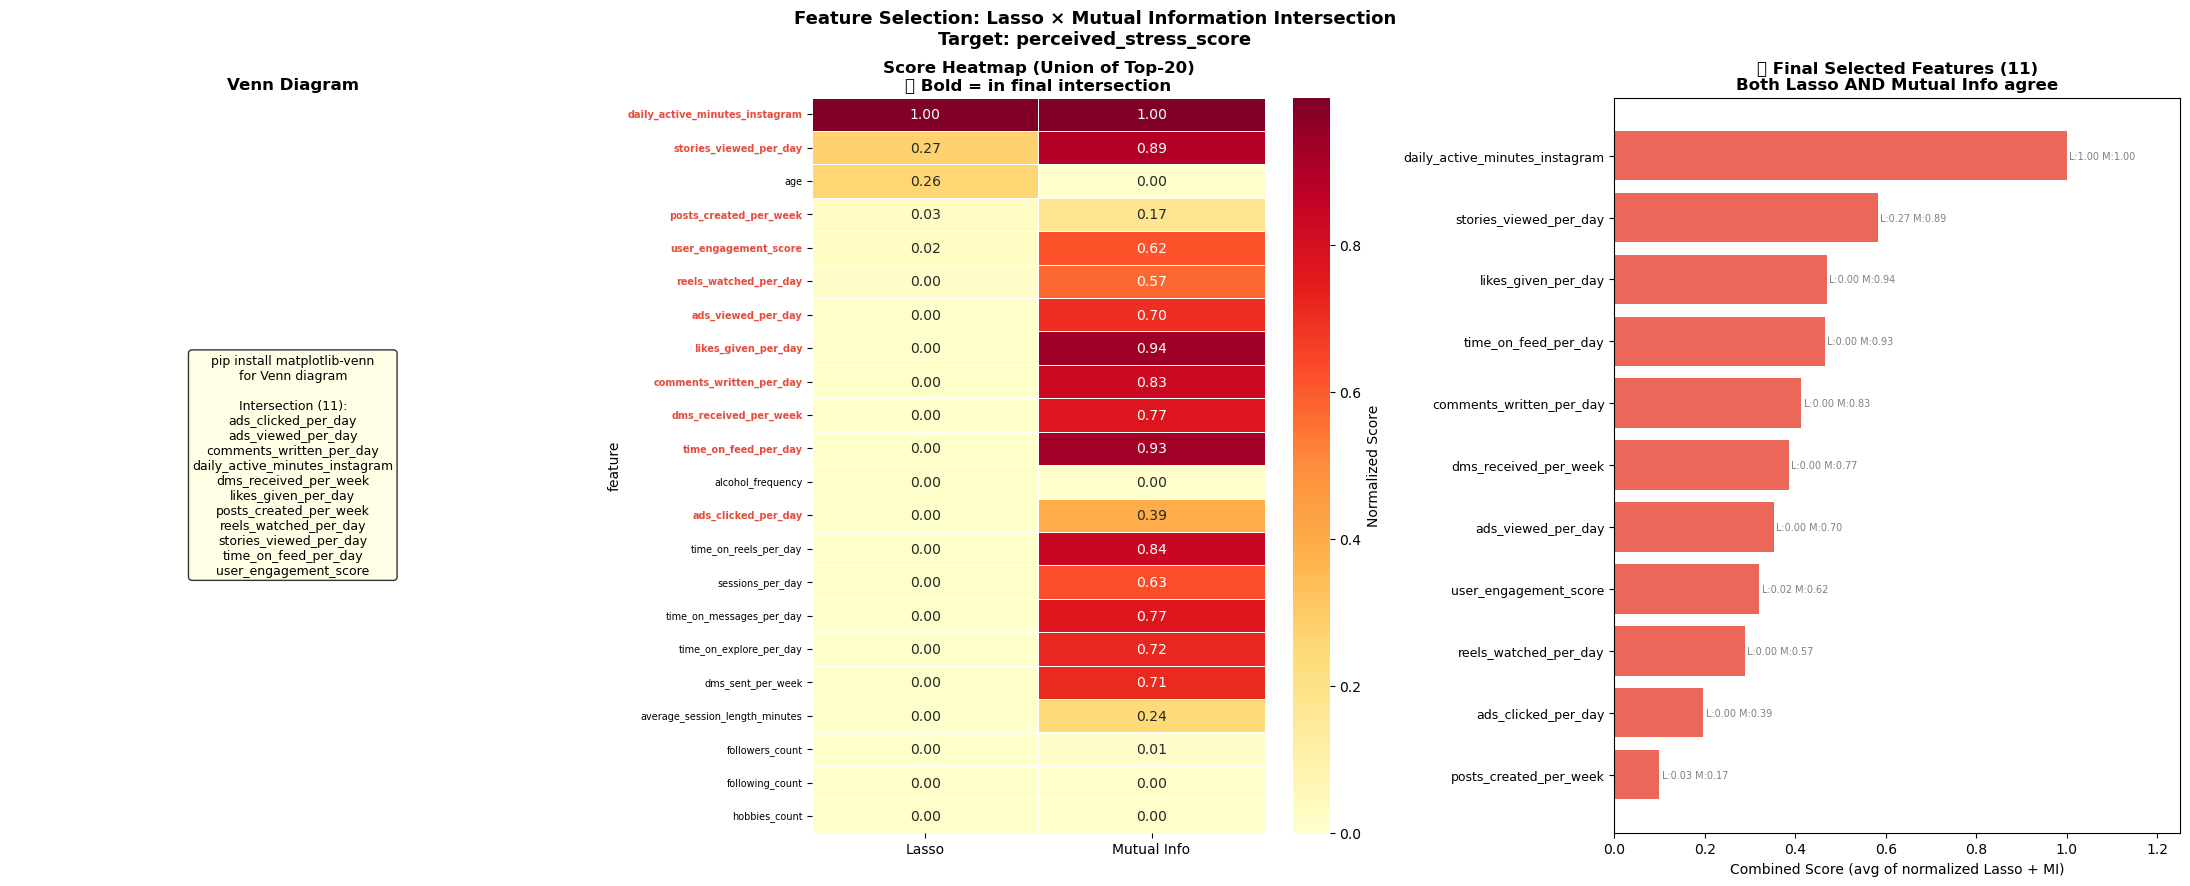

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 9))
fig.suptitle(
    "Feature Selection: Lasso × Mutual Information Intersection\n"
    "Target: perceived_stress_score",
    fontsize=13, fontweight='bold'
)

# ── Panel 1: Venn Diagram ─────────────────────────────────────────────────────
ax = axes[0]
try:
    from matplotlib_venn import venn2
    v = venn2(
        [lasso_top, mi_top],
        set_labels=(f'Lasso\n(Top-{TOP_K})', f'Mutual Info\n(Top-{TOP_K})'),
        ax=ax,
        set_colors=('#E74C3C', '#3498DB')
    )
    ax.set_title(f"Method Overlap\n Intersection = {len(intersection)} final features",
                 fontweight='bold')
except ImportError:
    # Fallback text if matplotlib-venn not installed
    ax.text(0.5, 0.5,
            f"pip install matplotlib-venn\nfor Venn diagram\n\n"
            f"Intersection ({len(intersection)}):\n" + "\n".join(final_list),
            ha='center', va='center', transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax.set_title("Venn Diagram", fontweight='bold')
    ax.axis('off')

# ── Panel 2: Heatmap ──────────────────────────────────────────────────────────
ax = axes[1]
union_features = list(lasso_top | mi_top)
hmap = combined[combined['feature'].isin(union_features)].set_index('feature')
hmap = hmap[['lasso_norm', 'mi_norm']].sort_values('lasso_norm', ascending=False)
hmap.columns = ['Lasso', 'Mutual Info']

sns.heatmap(hmap, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Normalized Score'})
ax.set_title(f"Score Heatmap (Union of Top-{TOP_K})\n Bold = in final intersection",
             fontweight='bold')
ax.tick_params(axis='y', labelsize=7)

# Highlight intersection feature labels in red
for label in ax.get_yticklabels():
    if label.get_text() in intersection:
        label.set_color('#E74C3C')
        label.set_fontweight('bold')

# ── Panel 3: Final intersection features bar chart ────────────────────────────
ax = axes[2]
if len(intersection) > 0:
    final_df = combined[combined['in_intersection']].sort_values(
        'combined_score', ascending=True
    )
    colors_bar = ['#E74C3C' if s > 0 else '#3498DB'
                  for s in lasso_df.set_index('feature').reindex(
                      final_df['feature'])['lasso_coef'].fillna(0)]
    bars = ax.barh(final_df['feature'], final_df['combined_score'],
                   color='#E74C3C', alpha=0.85)

    # Add lasso + MI scores as text annotations
    for i, (_, row) in enumerate(final_df.iterrows()):
        ax.text(row['combined_score'] + 0.005, i,
                f"L:{row['lasso_norm']:.2f} M:{row['mi_norm']:.2f}",
                va='center', fontsize=7, color='gray')

    ax.set_title(f" Final Selected Features ({len(intersection)})\n"
                 f"Both Lasso AND Mutual Info agree",
                 fontweight='bold')
    ax.set_xlabel("Combined Score (avg of normalized Lasso + MI)")
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xlim(0, 1.25)
else:
    ax.text(0.5, 0.5,
            f"No intersection with TOP_K={TOP_K}\nTry increasing TOP_K",
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title("No intersection — increase TOP_K", fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig("feature_selection_lasso_mi.png", dpi=150, bbox_inches='tight')
print("✅ Saved: feature_selection_lasso_mi.png")
plt.show()

---
## Section 8 — Summary

In [ ]:
print("=" * 60)
print("FINAL FEATURE SELECTION SUMMARY")
print("=" * 60)
print(f"\nTarget           : {TARGET}")
print(f"Total features   : {len(feature_cols)}")
print(f"Top-K per method : {TOP_K}")
print(f"Lasso alpha      : {lasso.alpha_:.6f}")
print(f"Lasso R² (test)  : {lasso.score(X_test_sc, y_test):.4f}")

print(f"\n Selection per method:")
print(f"   Lasso top-{TOP_K}      : {sorted(lasso_top)}")
print(f"   Mutual Info top-{TOP_K}: {sorted(mi_top)}")

print(f"\n FINAL INTERSECTION ({len(intersection)} features — both methods agree):")
final_ranked = combined[combined['in_intersection']].sort_values(
    'combined_score', ascending=False
)
for _, row in final_ranked.iterrows():
    lasso_coef = lasso_df[lasso_df['feature']==row['feature']]['lasso_coef'].values[0]
    direction  = "↑ increases stress" if lasso_coef > 0 else "↓ decreases stress"
    print(f"  • {row['feature']:<45} {direction}")

print(f"\n Tip: If intersection is too small → increase TOP_K (currently {TOP_K})")
print(f"        If intersection is too large → decrease TOP_K")

print("\n Output files:")
print("   final_selected_features.csv  ← feed directly into threshold model")
print("   all_features_ranked.csv       ← full ranking for reference")
print("   feature_selection_lasso_mi.png")
print("\n Done!")

FINAL FEATURE SELECTION SUMMARY

Target           : perceived_stress_score
Total features   : 53
Top-K per method : 20
Lasso alpha      : 0.009871
Lasso R² (test)  : 0.7286

📊 Selection per method:
   Lasso top-20      : ['ads_clicked_per_day', 'ads_viewed_per_day', 'age', 'alcohol_frequency', 'comments_written_per_day', 'daily_active_minutes_instagram', 'dms_received_per_week', 'likes_given_per_day', 'posts_created_per_week', 'reels_watched_per_day', 'stories_viewed_per_day', 'time_on_feed_per_day', 'user_engagement_score']
   Mutual Info top-20: ['ads_clicked_per_day', 'ads_viewed_per_day', 'average_session_length_minutes', 'comments_written_per_day', 'daily_active_minutes_instagram', 'dms_received_per_week', 'dms_sent_per_week', 'followers_count', 'following_count', 'hobbies_count', 'likes_given_per_day', 'posts_created_per_week', 'reels_watched_per_day', 'sessions_per_day', 'stories_viewed_per_day', 'time_on_explore_per_day', 'time_on_feed_per_day', 'time_on_messages_per_day', 'tim